In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
import seaborn as sns
from tensorflow.keras.datasets import mnist
from pyspark.sql.types import StructType,StructField, StringType, FloatType, ArrayType

2023-10-06 19:37:11.342051: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-06 19:37:11.392459: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-06 19:37:11.392499: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-06 19:37:11.392537: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-06 19:37:11.401813: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-06 19:37:11.402528: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# train, test load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [3]:
# PY SPARK VERSION OF THE DATAFRAME
# def get_ps_dataFrame(x_data,y_data):
#     data_unified = [( x_data[i].tolist(), str(y_data[i])) for i in range(len(x_data))]
#     schema = StructType([ 
#         StructField("image",ArrayType(ArrayType(FloatType())),False), 
#         StructField("class", StringType(), False) 
#       ])
#     df = spark.createDataFrame(data=data_unified,schema=schema)
#     return df
# train_df = get_ps_dataFrame(x_train, y_train)

In [4]:
# print((df.count(), len(df.columns)))

In [5]:
def get_pd_dataFrame(x_data,y_data):
    return pd.DataFrame(data={'image':x_data.tolist(), 'class':y_data.tolist()})
train_df = get_pd_dataFrame(x_train, y_train)

In [6]:
def augment_data_cross_same_class_pair(df:pd.DataFrame):
    sorted_df = df.sort_values("class").reset_index(drop=True)
    shuffled_sorted_df = sorted_df.sample(frac=1).reset_index(drop=True).sort_values("class").reset_index(drop=True)
    shuffled_sorted_df.rename(columns={'image':'imagePair',"class": "classPair"}, inplace=True)
    result = pd.concat([sorted_df, shuffled_sorted_df], axis=1)
    return result[['image','imagePair', 'class']].sample(frac=1).reset_index(drop=True)

same_class_cross_df = augment_data_cross_same_class_pair(train_df)

In [7]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

def series_to_tensor(series:pd.Series):
    tensor_list = list(series.apply(lambda x: tf.constant(x)))
    return tf.stack(tensor_list)

def split_df(df, frac = 0.1):
    copy_df = df.copy()
    test = copy_df.sample(frac=frac)
    train = copy_df.drop(test.index)
    return [train, test]
def prepare_data_traditional_autoencoder_data(df):
    [tr_df, val_df] = split_df(df, frac=0.1)
    
    image_tensor = series_to_tensor(tr_df['image'])
    in_x_train = image_tensor
    out_x_train = image_tensor
    
    image_val_tensor = series_to_tensor(val_df['image'])
    in_x_val = image_val_tensor
    out_x_val = image_val_tensor
    
    return [in_x_train, out_x_train, in_x_val, out_x_val]

def prepare_train_cross_same_class_autoencoder_data(df, additional_same_class_df):
    original_df =  df.copy()
    original_df["imagePair"] = original_df["image"]
    concat_df = pd.concat([original_df, additional_same_class_df])
    concat_df = concat_df.sample(frac=1).reset_index(drop=True)
    
    concat_train_df, concat_validation_df = split_df(concat_df, frac=0.1)
    in_x_train = series_to_tensor(concat_train_df['image'])
    out_x_train = series_to_tensor(concat_train_df['imagePair'])
    in_x_val = series_to_tensor(concat_validation_df['image'])
    out_x_val = series_to_tensor(concat_validation_df['imagePair'])
    return [in_x_train, out_x_train,in_x_val, out_x_val]


In [8]:
[trad_ae_x_in,  trad_ae_x_out, trad_ae_x_in_val, trad_ae_x_out_val]= prepare_data_traditional_autoencoder_data(train_df)

[cross_same_class_ae_x_in,  cross_same_class_ae_x_out, cross_same_class_ae_x_in_val, cross_same_class_ae_x_out_val]= prepare_train_cross_same_class_autoencoder_data(train_df, same_class_cross_df)



In [9]:
from keras import layers
class ConvolutionalAutoencoder(keras.Model):
    def __init__(self,  input_shape ):
        super(ConvolutionalAutoencoder, self).__init__(input_shape,input_shape)
        self.shape = input_shape
        self.encoder = tf.keras.Sequential([
            input_shape,
            layers.Conv2D(16, (3, 3), activation='relu'),
            layers.MaxPooling2D((2,2), padding='same'),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2,2), padding='same'),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2,2), padding='same'),
        ])
        encoder_output_shape = self.encoder.layers[-1].output_shape
        self.decoder = tf.keras.Sequential([
            layers.Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=encoder_output_shape[1:]),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(16, (3, 3), activation='relu'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'),
        ])

    def call(self, inputs,training = False):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded



In [10]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.cluster import rand_score
from sklearn.metrics import f1_score

def calculate_embed_vectors(model,x_data):
    #run encoder to get embeded vector in latent space     
    result = model.encoder.predict(x_data)
    #flat array into 1d array (vector)     
    return np.array(list(map(lambda x: x.flatten(), result)))

def calculate_centroids(vectors, y_data):
    classes = np.unique(y_data)
    class_vectors = {}
    for img_class in classes:
        class_vectors[img_class] = np.mean(vectors[np.where(y_data == img_class)], axis=0)        
    return class_vectors

def get_estimated_class(model, x_data, y_data):
    vectors = calculate_embed_vectors(model,x_data)
    class_centroids = calculate_centroids(vectors, y_data)
    classes = np.array(list(class_centroids.keys()))
    centroids = np.array(list(class_centroids.values()))
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(centroids,classes)
    return knn.predict(vectors)

def calculate_rand_index(model, x_data, y_data):
    labels_pred = get_estimated_class(model, x_data, y_data)
    return {
        'rand_score':rand_score(y_data,labels_pred),
        'f1_score':f1_score(y_data,labels_pred,average='macro')
           } 

In [11]:
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping

class ExperimentConfig:
    def __init__(self):
        self.name = ""
        self.model = None
        self.x_input_train = None
        self.x_output_train = None
        self.x_input_val = None
        self.x_output_val = None
        self.x_data_test = None
        self.y_data_test = None
        self.max_epochs = 3
        self.batch_size = 200
    
def train_model(exp_config : ExperimentConfig):
    exp_config.model.compile(optimizer='adam', loss='mse')

    # specify the path where you want to save your models
    checkpoint_file_path =  f'./checkpoints/{exp_config.name}'
    
    # create a model checkpoint callback
    checkpoint = ModelCheckpoint(
        checkpoint_file_path, 
        monitor='val_loss',
        verbose=0, 
        save_weights_only=True, 
        save_best_only=False,
        mode='min', 
        save_freq="epoch")
    
    #early stopping mechanism to avoid waste resources     
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, start_from_epoch=15)
    
    history = exp_config.model.fit(exp_config.x_input_train, exp_config.x_output_train,
                    epochs=exp_config.max_epochs,
                    batch_size=exp_config.batch_size,
                    shuffle=True,
                    validation_data=(exp_config.x_input_val, exp_config.x_output_val),
                    callbacks=[checkpoint,early_stopping])
    
    return exp_config.model, history

def plot_history(exp_config, history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{exp_config.name} model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
def run_experiment( exp_config : ExperimentConfig):
    model, history = train_model(exp_config)
    plot_history(exp_config, history) 
    result = calculate_rand_index(model, exp_config.x_data_test, exp_config.y_data_test) 
    print(result)
    return model
    

In [12]:
def load_data_traditional_ae(config: ExperimentConfig):
    config.x_input_train = trad_ae_x_in
    config.x_output_train = trad_ae_x_out
    config.x_input_val = trad_ae_x_in_val
    config.x_output_val = trad_ae_x_out_val
    config.x_data_test = x_test
    config.y_data_test = y_test
    return config

def load_data_cross_same_class_ae(config: ExperimentConfig):
    config.x_input_train = cross_same_class_ae_x_in
    config.x_output_train = cross_same_class_ae_x_out
    config.x_input_val = cross_same_class_ae_x_in_val
    config.x_output_val = cross_same_class_ae_x_out_val
    config.x_data_test = x_test
    config.y_data_test = y_test
    return config

In [13]:
def config_and_run_ae(name, model, config_data_loader, max_epochs = 100):
    config = ExperimentConfig()
    config.name = name
    config.model = model
    config.max_epochs = max_epochs
    config = config_data_loader(config)
    run_experiment(config)
    

Epoch 1/3
270/270 [==============================] - 13s 44ms/step - loss: 0.1148 - val_loss: 0.1120
Epoch 2/3
270/270 [==============================] - 11s 41ms/step - loss: 0.1120 - val_loss: 0.1120
Epoch 3/3
270/270 [==============================] - 11s 41ms/step - loss: 0.1120 - val_loss: 0.1120


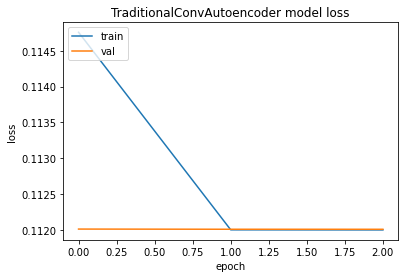

313/313 [==============================] - 1s 2ms/step
{'rand_score': 0.8727764376437643, 'f1_score': 0.575552290454531}


In [14]:
input_shape = keras.Input(shape=(28, 28, 1))
conv_model = ConvolutionalAutoencoder( input_shape)
config_and_run_ae("TraditionalConvAutoencoder",conv_model, load_data_traditional_ae)


Epoch 1/3
540/540 [==============================] - 25s 43ms/step - loss: 0.1150 - val_loss: 0.1118
Epoch 2/3
540/540 [==============================] - 23s 42ms/step - loss: 0.1120 - val_loss: 0.1118
Epoch 3/3
540/540 [==============================] - 23s 43ms/step - loss: 0.1120 - val_loss: 0.1118


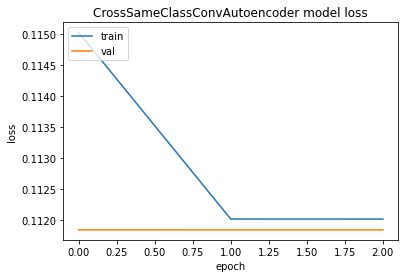

313/313 [==============================] - 1s 2ms/step
{'rand_score': 0.8836078607860786, 'f1_score': 0.6135064830501086}


In [15]:
input_shape = keras.Input(shape=(28, 28, 1))
csc_conv_model = ConvolutionalAutoencoder( input_shape)
config_and_run_ae("CrossSameClassConvAutoencoder",csc_conv_model, load_data_cross_same_class_ae)


In [16]:
from keras import layers
def multiply_tuple_values(tuple_values):
    result = 1
    for value in tuple_values:
        result *= value
    return result
class DenseAutoencoder(keras.Model):
    def __init__(self, latent_dim, input_shape ):
        super(DenseAutoencoder, self).__init__(input_shape,input_shape)
        shape = tuple(input_shape.shape[1:])
        self.encoder = tf.keras.Sequential([
            layers.Flatten(input_shape=shape),
            layers.Dense(60, activation='relu'),
            layers.Dense(20, activation='relu'),
            layers.Dense(12, activation='relu'),
            layers.Dense(latent_dim, activation='relu'),
        ])
        output_size = multiply_tuple_values(shape) 
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            
            layers.Dense(12, activation='relu', input_shape=(latent_dim,)),
            layers.Dense(20, activation='relu'),
            layers.Dense(60, activation='relu'),
            layers.Dense(output_size, activation='sigmoid'),
            layers.Reshape(target_shape=shape),
        ])

    def call(self, inputs,training = False):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded



Epoch 1/3
270/270 [==============================] - 3s 5ms/step - loss: 0.0783 - val_loss: 0.0606
Epoch 2/3
270/270 [==============================] - 1s 4ms/step - loss: 0.0581 - val_loss: 0.0559
Epoch 3/3
270/270 [==============================] - 1s 4ms/step - loss: 0.0546 - val_loss: 0.0535


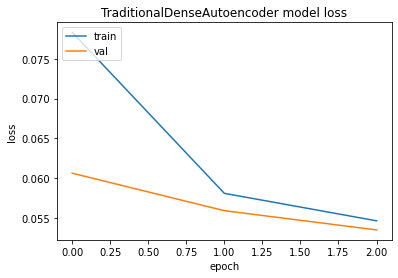

313/313 [==============================] - 0s 1ms/step
{'rand_score': 0.8419945194519451, 'f1_score': 0.3647518859937866}


In [17]:

input_shape = keras.Input(shape=(28, 28, 1))

latent_dim = 2
trad_dense_ae = DenseAutoencoder(latent_dim, input_shape)

config_and_run_ae("TraditionalDenseAutoencoder",trad_dense_ae, load_data_traditional_ae, max_epochs=600)



Epoch 1/3
540/540 [==============================] - 4s 4ms/step - loss: 0.0748 - val_loss: 0.0639
Epoch 2/3
540/540 [==============================] - 2s 4ms/step - loss: 0.0614 - val_loss: 0.0598
Epoch 3/3
540/540 [==============================] - 2s 4ms/step - loss: 0.0594 - val_loss: 0.0591


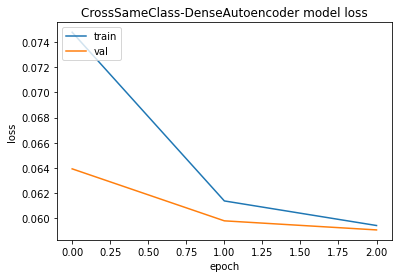

313/313 [==============================] - 1s 1ms/step
{'rand_score': 0.8759815181518151, 'f1_score': 0.4863695659289865}


In [18]:

input_shape = keras.Input(shape=(28, 28, 1))

latent_dim = 2
csc_dense_ae = DenseAutoencoder(latent_dim, input_shape)

config_and_run_ae("CrossSameClass-DenseAutoencoder",csc_dense_ae, load_data_cross_same_class_ae, max_epochs=600)


In [19]:
def points_to_df(X, y):    
    data = np.concatenate((X, y.reshape(-1, 1)), axis=1) 
    column_names = ["x", "y", "class"] 
    return pd.DataFrame(data, columns=column_names)
def plot_points(name, model, x_data, y_data):
    unique_classes , _ = tf.unique(y_data)
    num_classes = tf.size(unique_classes).numpy()
    pallet = sns.color_palette("Spectral",num_classes).as_hex()
    
    vectors = calculate_embed_vectors(model,x_data)
    points_df = points_to_df(vectors, y_data)
    points_df['color'] = points_df['class'].map(lambda x: pallet[int(x)])
    points_df.plot.scatter(x=0,y=1, c='color').set_title(name)

313/313 [==============================] - 0s 1ms/step


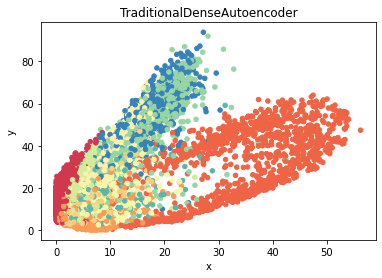

In [20]:
plot_points("TraditionalDenseAutoencoder",trad_dense_ae, x_test, y_test)

313/313 [==============================] - 0s 1ms/step


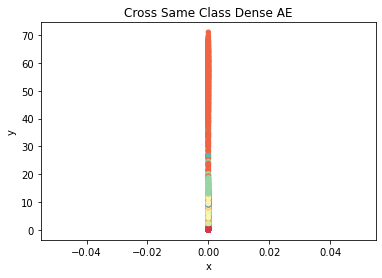

In [21]:
plot_points("Cross Same Class Dense AE",csc_dense_ae, x_test, y_test)

In [22]:

# LOAD SAVED MODEL FROM CHECK POINT
# ae.load_weights(checkpoint_file_path)

In [23]:
# prepare data aumentated for same class match
# train SCAE 
# plot loss SCAE

In [24]:
# calculate encoded_vector_ae using autoencoder
# calculate encoded_vector_vae using Variational autoencoder

In [25]:
# create function to calculate metric topK class metric
# calculateMetric(encoded_vector_ae)
# calculateMetric(encoded_vector_vae)

In [26]:
# data visualisation metrics

In [27]:
# discuss results

In [28]:
# if there is time, apply in another dataset